# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

- this is a classification problem. 
- Classification deals with assigning categories or labels to data samples, whilst regression aims to predict a numeric value from a continuous range. (It may also be seen as real-valued function approximation). 
- In this case we wish to classify students into one of 2 categories, (needs intervention / does not need intervention), hence it's a classification problem. Note, that we may still output numerical values, indicating the probability of membership of each category for a sample, but the fact that we are classifying into categories makes this a classification rather than a regression problem.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
student_data.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   ...   internet romantic  famrel  freetime  goout Dalc Walc health absences  \
0  ...         no       no       4         3      4    1    1      3        6   
1  ...        yes       no       5         3      3    1    1      3        4   
2  ...        yes       no       4         3      2    2    3      3       10   
3  ...        yes      yes       3         2      2    1    1      5        2   
4  ...         no       no       4         3      2    1    2      5        4   

  passed  
0     no  
1     no  
2    yes  
3    yes  
4    yes  

[5 rows x 31 columns]

In [3]:
from __future__ import division # avoid any unexpected integer math nasties.

# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns) -1 
# N.B. subtract one since one column is the label, not a feature.

# TODO: Calculate passing students
n_passed = len(student_data[student_data['passed'] == 'yes'])

# TODO: Calculate failing students
n_failed = len(student_data[student_data['passed'] == 'no'])

# TODO: Calculate graduation rate
grad_rate = 100.0 * n_passed/n_students

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [4]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [5]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


count       mean       std   min   25%   50%   75%   max
school_GP          395.0   0.883544  0.321177   0.0   1.0   1.0   1.0   1.0
school_MS          395.0   0.116456  0.321177   0.0   0.0   0.0   0.0   1.0
sex_F              395.0   0.526582  0.499926   0.0   0.0   1.0   1.0   1.0
sex_M              395.0   0.473418  0.499926   0.0   0.0   0.0   1.0   1.0
age                395.0  16.696203  1.276043  15.0  16.0  17.0  18.0  22.0
address_R          395.0   0.222785  0.416643   0.0   0.0   0.0   0.0   1.0
address_U          395.0   0.777215  0.416643   0.0   1.0   1.0   1.0   1.0
famsize_GT3        395.0   0.711392  0.453690   0.0   0.0   1.0   1.0   1.0
famsize_LE3        395.0   0.288608  0.453690   0.0   0.0   0.0   1.0   1.0
Pstatus_A          395.0   0.103797  0.305384   0.0   0.0   0.0   0.0   1.0
Pstatus_T          395.0   0.896203  0.305384   0.0   1.0   1.0   1.0   1.0
Medu               395.0   2.749367  1.094735   0.0   2.0   3.0   4.0   4.0
Fedu               395.0   2.521519  1.088201   0.0   2.0   2.0   3.0   4.0
Mjob_at_home       395.0   0.149367  0.356902   0.0   0.0   0.0   0.0   1.0
Mjob_health        395.0   0.086076  0.280832   0.0   0.0   0.0   0.0   1.0
Mjob_other         395.0   0.356962  0.479711   0.0   0.0   0.0   1.0   1.0
Mjob_services      395.0   0.260759  0.439606   0.0   0.0   0.0   1.0   1.0
Mjob_teacher       395.0   0.146835  0.354391   0.0   0.0   0.0   0.0   1.0
Fjob_at_home       395.0   0.050633  0.219525   0.0   0.0   0.0   0.0   1.0
Fjob_health        395.0   0.045570  0.208814   0.0   0.0   0.0   0.0   1.0
Fjob_other         395.0   0.549367  0.498188   0.0   0.0   1.0   1.0   1.0
Fjob_services      395.0   0.281013  0.450064   0.0   0.0   0.0   1.0   1.0
Fjob_teacher       395.0   0.073418  0.261152   0.0   0.0   0.0   0.0   1.0
reason_course      395.0   0.367089  0.482622   0.0   0.0   0.0   1.0   1.0
reason_home        395.0   0.275949  0.447558   0.0   0.0   0.0   1.0   1.0
reason_other       395.0   0.091139  0.288172   0.0   0.0   0.0   0.0   1.0
reason_reputation  395.0   0.265823  0.442331   0.0   0.0   0.0   1.0   1.0
guardian_father    395.0   0.227848  0.419976   0.0   0.0   0.0   0.0   1.0
guardian_mother    395.0   0.691139  0.462610   0.0   0.0   1.0   1.0   1.0
guardian_other     395.0   0.081013  0.273201   0.0   0.0   0.0   0.0   1.0
traveltime         395.0   1.448101  0.697505   1.0   1.0   1.0   2.0   4.0
studytime          395.0   2.035443  0.839240   1.0   1.0   2.0   2.0   4.0
failures           395.0   0.334177  0.743651   0.0   0.0   0.0   0.0   3.0
schoolsup          395.0   0.129114  0.335751   0.0   0.0   0.0   0.0   1.0
famsup             395.0   0.612658  0.487761   0.0   0.0   1.0   1.0   1.0
paid               395.0   0.458228  0.498884   0.0   0.0   0.0   1.0   1.0
activities         395.0   0.508861  0.500555   0.0   0.0   1.0   1.0   1.0
nursery            395.0   0.794937  0.404260   0.0   1.0   1.0   1.0   1.0
higher             395.0   0.949367  0.219525   0.0   1.0   1.0   1.0   1.0
internet           395.0   0.832911  0.373528   0.0   1.0   1.0   1.0   1.0
romantic           395.0   0.334177  0.472300   0.0   0.0   0.0   1.0   1.0
famrel             395.0   3.944304  0.896659   1.0   4.0   4.0   5.0   5.0
freetime           395.0   3.235443  0.998862   1.0   3.0   3.0   4.0   5.0
goout              395.0   3.108861  1.113278   1.0   2.0   3.0   4.0   5.0
Dalc               395.0   1.481013  0.890741   1.0   1.0   1.0   2.0   5.0
Walc               395.0   2.291139  1.287897   1.0   1.0   2.0   3.0   5.0
health             395.0   3.554430  1.390303   1.0   3.0   4.0   5.0   5.0
absences           395.0   5.708861  8.003096   0.0   0.0   4.0   8.0  75.0

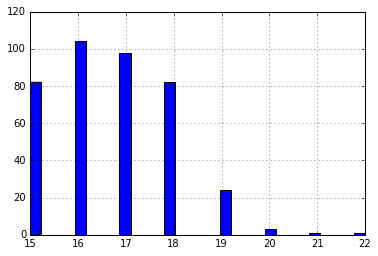

In [6]:
# some further data exploration for interest..
%matplotlib inline
X_all['age'].hist(bins=30)
X_all.describe().transpose()


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [7]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split
RANDOM_STATE=42

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=num_test, random_state=RANDOM_STATE)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])
print "Training set has {} labels.".format(y_train.shape[0])
print "Testing set has {} labels.".format(y_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.
Training set has 300 labels.
Testing set has 95 labels.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

3 models that are appropriate for the problem are:

1) Gaussian Naive Bayes.
  - uses: spam detection, and document classification. (https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering)
  - strengths are:
    - that it is extremely fast
    - handles large numbers of features well.
    - doesn't require a lot of training data
  - weaknesses:
    - doesn't model relationships/correlations between the features, so if this is a significant feature of the data then performance may in principle suffer. Rarely an issue in practice though. ("Optimality of Naive Bayes", by H. Zhang elaborates on why this is.)
    - since probability used in the classification is constructed from the product of the probabilities based on each of the individual features, then missing or bad/noisy data for one feature could affect the whole classification.
  - suitable for this problem, since we have relatively small amounts of seemingly low-noise training data, with lots of features.
        
2) Ensemble methods, e.g. Adaboost with Decision Tree learners.
- uses: Pedestrian detection from images: https://en.wikipedia.org/wiki/Boosting_(machine_learning)#cite_note-14
- strengths:
  - resistant to overfitting, provided that underlying weak learners are relatively weak and not themselves prone to overfitting; also provided that the data is relatively noise free.
- weaknesses:
  - will overfit to very noisy or misclassified data.
- suitable here, since data seems to be relatively low noise. Individual feature decision tree stubs would make suitable weak learners.
        
3) Logistic Regression
- uses:
  - widely used in medical and social sciences and engineering and economics. One example is the prediction of mortality rates of injured patients in the "Trauma and Injury Severity Score". (see:  https://en.wikipedia.org/wiki/Logistic_regression#cite_note-5)
  - strengths: a fast, a conceptually simple yet effective classifier.
  - weaknesses: less powerful than some other classifiers, in terms of the complexity of the decision boundary that it can support (which is effectively a linear separator).
  - suitable here: given that we require a fact clasifier to reduce computational costs, and have a large number of dimensions so the limitations of a linear decision surface are likely to be less significant.
 
*Intuition on the whole list (for my own notes - please feel free to comment on any incorrect intuitions here.)*
- Gaussian Naive Bayes. - good. fast.
- Decision trees ~ no. Have a tendency to overfit. we have a lot of dimensions, and would need a deep tree to utilise them, making us very suspeptible to overfitting.
- Ensemble methods - yes. the smoothing across learners reduces the likelyhood of overfitting, whilst still allowing many dimensions to be considered, as part of the classification decision. e.g. AdaBoost, or RandomForests.
- KNN - No - too many dimensions. not enough data to provide good coverage, and all attributes considered equally
- Stochastic Gradient Descent. Simple and effective approach. Can also handle many features. Would also be worth consideration. 
- Support Vector Machines - powerful technique. handles many dimensions well. limitations: doesn't scale well to big datasets since it is computationally expensive.
- Logistic Regression - would be also be suitable. Simple and often effective type of classifier. Potentially less powerful at separating the classes than some of the other methods however.


### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [8]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [9]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state=RANDOM_STATE)
clf_C = LogisticRegression(random_state=RANDOM_STATE)

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

# Execute the 'train_predict' function for each classifier and each training set size
sizes = [100,200,300]
clf = clf_C
print '-------------'
train_predict(clf, X_train_100, y_train_100, X_test, y_test)
print '-------------'
train_predict(clf, X_train_200, y_train_200, X_test, y_test)
print '-------------'
train_predict(clf, X_train_300, y_train_300, X_test, y_test)

-------------
Training a LogisticRegression using a training set size of 100. . .
Trained model in 0.0016 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 0.8593.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.7647.
-------------
Training a LogisticRegression using a training set size of 200. . .
Trained model in 0.0027 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: 0.8562.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.7914.
-------------
Training a LogisticRegression using a training set size of 300. . .
Trained model in 0.0028 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 0.8468.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.8060.


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Gaussian Naive Bayes **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |       0.0014            |         0.0004         |   0.8467         |   0.8029        |
| 200               |       0.0007            |         0.0003         |   0.8406         |   0.7244        |
| 300               |       0.0007            |         0.0003         |   0.8038         |   0.7634        |

** Classifer 2 - Adaboost with underlying Decision Tree Classifier ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |    0.1176               |       0.0036           |    0.9481        |    0.7669       |
| 200               |    0.0756               |       0.0038           |    0.8927        |    0.8281       |
| 300               |    0.1142               |       0.0043           |    0.8637        |    0.7820       |

** Classifer 3 - Logistic Regression **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |    0.0011               |   0.0002               |   0.8593         |   0.7647        |
| 200               |    0.0021               |   0.0005               |   0.8562         |   0.7914        |
| 300               |    0.0050               |   0.0004               |   0.8468         |   0.8060        |

*Some additional investigation notes*

** *(Support Vector Classifier with Radial Basis Function kernel)* **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |    0.0018               |   0.0008               |   0.8777         |   0.7746        |
| 200               |    0.0029               |   0.0010               |   0.8679         |   0.7815        |
| 300               |    0.0093               |   0.0020               |   0.8761         |   0.7838        |


## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

The Logistic Regression model was chosen.

The classification performance of all 3 models initially considered was comparable based on initial tests without detailed fine tuning.
However, given that computation cost is a factor, the Adaboost model was rejected as it takes more time for both training and making predictions once trained, resulting in higher computation costs.

Logistic Regression was chosen over Naive Bayes, since the Naive Bayes model has no tunable parameters, meaning there's little potential to improve it's performance further beyond the default model, whilst Logistic Regression does have parameters to be further refined.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

The chosen model (a Logistic Regression classifier) works by trying to calculate a probability that a student will pass, by looking at the properties of the data in the training set.

The model is constructed in a way that it can calculate an output score lying between 0 and 1, by considering all of the features of a student record (except the pass/fail column itself).  The score can be considered as the probability that the student passes, so scores over 50% are classified as a predicted pass, and below 50% classified as requiring intervention.

Internally, the model holds a number of "weights", which are a set of numbers, on which it bases it's calculation, by combining them with the data in the student record. The model is "trained" by setting its weights using an algorithm which adjusts them to give the least error when classifying all the records in the training data set. 

Once trained in this way, the model with these "learned" weights can be used to classify new student records and hence "predict" which students are likely to pass and which may benefit from intervention.


### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [10]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {
   'C': [ .037, .038, .039, .04, .041, .042, 0.05,.06, 0.01, 0.1, 0.25, 0.5, 1.0, 2.0]
}

# TODO: Initialize the classifier
clf = LogisticRegression(random_state=RANDOM_STATE)

print "Model parameters:", clf.get_params()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer, cv=8, verbose=1, n_jobs=4)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print "best score", grid_obj.best_score_
print "best classifier params:", clf.get_params()
# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Model parameters: {'warm_start': False, 'C': 1.0, 'n_jobs': 1, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': 42, 'dual': False, 'tol': 0.0001, 'solver': 'liblinear', 'class_weight': None}
Fitting 8 folds for each of 14 candidates, totalling 112 fits
best score 0.82217792855
best classifier params: {'warm_start': False, 'C': 0.038, 'n_jobs': 1, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': 42, 'dual': False, 'tol': 0.0001, 'solver': 'liblinear', 'class_weight': None}
Made predictions in 0.0003 seconds.
Tuned model has a training F1 score of 0.8326.
Made predictions in 0.0002 seconds.
Tuned model has a testing F1 score of 0.7778.


[Parallel(n_jobs=4)]: Done 112 out of 112 | elapsed:    0.4s finished


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

- Tuned model has a training F1 score of 0.8326.
- Tuned model has a testing F1 score of 0.7778.

- Both training and testing F1 scores are slightly lower than those for the untuned model. However that may be just that this particular (randomly selected) test data is by chance well suited to the default parameters of the model.
Hence, I'd have confidence that the tuned model generalises better to other datasets, since it was tuned based on it's generalisation (cross-validations) performance. Indeed the cross-validation score of the default model (0.783) is somewhat worse than that of the tuned model (0.822).

(To check the validity of this explanation, the tests were re-run with a different random seed, and indeed, all other things being unchanged, the tuned test performance was then seen to be better than the untuned test performance).

Exploratory Notes: Best **cross-validation** scores for various classifier types:

- Gaussian Naive Bayes classifier = 0.758
- Adaboost = 0.835
- SVC = 0.828
- Logistic Regression = 0.822


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.